In [1]:
%matplotlib inline
# import standard python modules
import numpy as np 
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Python classes for doing deconvolution
from pax_deconvolve.deconvolution import deconvolvers    

# Python module for estimating when deconvolutions have converged to a sufficient degree
from pax_deconvolve.deconvolution import assess_convergence

# Python module for visualizing the results of the deconvolution
import pax_deconvolve.visualize as visualize

In [2]:
# set simulation parameters
LOG10_NUM_ELECTRONS = 5.0  # 10^7 detected electrons (over entire dateset)
NUM_SIMULATIONS = 100    # Number of PAX spectra to simulate
ENERGY_LOSS = np.arange(-8, 10, 0.01)  # energy loss values of RIXS to simulate over
REGULARIZATION_STRENGTHS = np.logspace(-3, -1, 10)  # Regularization strengths to try
ITERATIONS = 100    # Number of iterations to run simulations for
CV_FOLD = 3   # Number of folds to use for cross validation

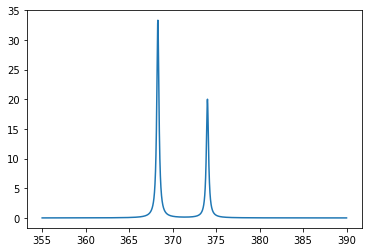

In [3]:
# Make up photoemission spectrum and corresponding impulse response function
b2 = 0.15    # Half of photoemission peak broadening
binding_energies = np.arange(355, 390, 0.01)
photoemission_spectrum = 5*(b2)/((binding_energies-368.3)**2+(b2)**2)+3*(b2)/((binding_energies-374.0)**2+(b2)**2)
norm_factor = np.sum(photoemission_spectrum)
impulse_response = {
    'x': -1*binding_energies,
    'y': np.flipud(photoemission_spectrum)/norm_factor
}
plt.figure()
plt.plot(binding_energies, photoemission_spectrum)

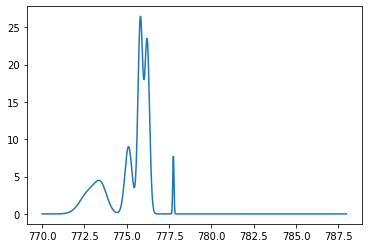

In [4]:
# Make up X-ray spectrum
photon_energies = np.arange(770, 788, 0.02)
p1 = 8*np.exp(-((photon_energies-777.75)/0.05)**2)
p2 = 23*np.exp(-((photon_energies-776.2)/0.2)**2)
p3 = 26*np.exp(-((photon_energies-775.8)/0.2)**2)
p4 = 9*np.exp(-((photon_energies-775.1)/0.3)**2)
p5 = 3*np.exp(-((photon_energies-773.5)/0.5)**2)
p6 = 3*np.exp(-((photon_energies-772.8)/0.75)**2)
xray_spectrum = p1+p2+p3+p4+p5+p6
plt.figure()
plt.plot(photon_energies, xray_spectrum)

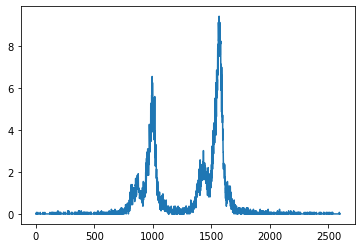

In [5]:
# Calculate PAX spectra
noiseless_pax_spectrum = convolve(
    xray_spectrum,
    impulse_response['y'],
    mode='valid'
)
num_pax_spectra = 5
counts = 10.0**LOG10_NUM_ELECTRONS 
single_photon = num_pax_spectra*np.sum(noiseless_pax_spectrum)/counts
pax_spectra = []
for i in range(num_pax_spectra):
    pax_spectrum = np.random.poisson(noiseless_pax_spectrum/single_photon)*single_photon
    pax_spectra.append(pax_spectrum)

# plot an example pax spectrum
plt.figure()
plt.plot(pax_spectra[0])

In [6]:
# Caclulate PAX spectra (new)
from pax_deconvolve.pax_simulations import simulate_pax
impulse_response, pax_spectra = simulate_pax.simulate({'x': photon_energies,
                                                       'y': xray_spectrum}, 
                                                     {'x': binding_energies,
                                                     'y': photoemission_spectrum},
                                                     10.0**LOG10_NUM_ELECTRONS,
                                                     500)

In [7]:
# Perform deconvolution
deconvolver = deconvolvers.LRFisterGrid(
    impulse_response['x'],
    impulse_response['y'],
    pax_spectra['x'],
    REGULARIZATION_STRENGTHS,
    ITERATIONS,
    xray_spectrum,
    CV_FOLD
)
# the ground truth X-ray spectrum is not known for real experiments and thus is an optional input argument to the deconvolver
_ = deconvolver.fit(np.array(pax_spectra['y']))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished


770.0
415.0


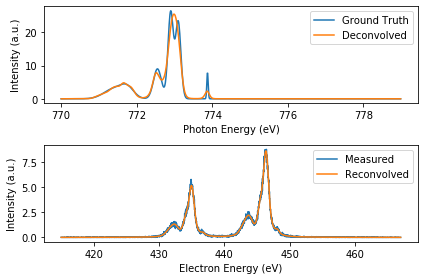

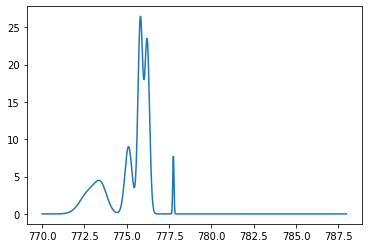

In [8]:
# Show result using function defined to do so
visualize.plot_result(deconvolver)
plt.figure()
plt.plot(photon_energies, xray_spectrum)
print(deconvolver.deconvolved_x[0])
print(deconvolver.convolved_x[0])

[770.   770.01 770.02 770.03 770.04 770.05 770.06 770.07 770.08 770.09
 770.1  770.11 770.12 770.13 770.14 770.15 770.16 770.17 770.18 770.19
 770.2  770.21 770.22 770.23 770.24 770.25 770.26 770.27 770.28 770.29
 770.3  770.31 770.32 770.33 770.34 770.35 770.36 770.37 770.38 770.39
 770.4  770.41 770.42 770.43 770.44 770.45 770.46 770.47 770.48 770.49
 770.5  770.51 770.52 770.53 770.54 770.55 770.56 770.57 770.58 770.59
 770.6  770.61 770.62 770.63 770.64 770.65 770.66 770.67 770.68 770.69
 770.7  770.71 770.72 770.73 770.74 770.75 770.76 770.77 770.78 770.79
 770.8  770.81 770.82 770.83 770.84 770.85 770.86 770.87 770.88 770.89
 770.9  770.91 770.92 770.93 770.94 770.95 770.96 770.97 770.98 770.99
 771.   771.01 771.02 771.03 771.04 771.05 771.06 771.07 771.08 771.09
 771.1  771.11 771.12 771.13 771.14 771.15 771.16 771.17 771.18 771.19
 771.2  771.21 771.22 771.23 771.24 771.25 771.26 771.27 771.28 771.29
 771.3  771.31 771.32 771.33 771.34 771.35 771.36 771.37 771.38 771.39
 771.4

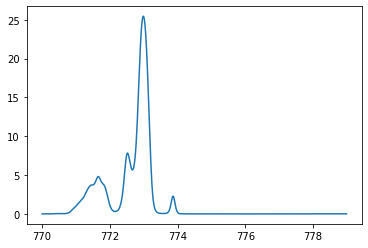

In [9]:
# plot result manually
plt.figure()
plt.plot(deconvolver.deconvolved_x, deconvolver.deconvolved_y_)
print(deconvolver.deconvolved_x)

In [10]:
# save result
np.savetxt('test.csv', deconvolver.deconvolved_y_)
array = np.genfromtxt('file_name.csv')
x = array[:, 0]
y = array[:, 1]

OSError: file_name.csv not found.

In [ ]:
dir(deconvolver)

In [ ]:
deconvolver.best_regularization_strength_